<a href="https://colab.research.google.com/github/tada20001/NLP_2023/blob/main/CH17_02_%EB%B2%84%ED%8A%B8(Bidirectional_Encoder_Representations_from_Transformers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.9 MB/s eta 0:00:00


### 1. BERT 개요
--------------
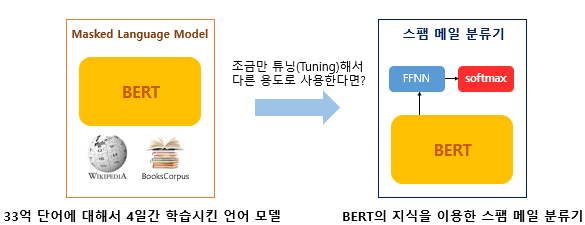

BERT는 이전 챕터에서 배웠던 트랜스포머를 이용하여 구현되었으며, 위키피디아(25억 단어)와 BooksCorpus(8억 단어)와 같은 레이블이 없는 텍스트 데이터로 사전 훈련된 언어모델임

BERT가 높은 성능을 얻을 수 있었던 것은, 레이블이 없는 방대한 데이터로 사전 훈련된 모델을 가지고, 레이블이 있는 작업에서 추가 훈련과 함께 하이퍼파라미터를 재조정하여 이 모델을 사용하면 성능이 높게 나오는 기존의 사례들을 참고하였기 때문임

다른 작업에 대해 파라미터 재조정을 위한 추가 훈련과정을 파인 튜닝(Fine-Tunning)이라고 함

위의 그림은 BERT의 파인 튜닝 사례를 보여줌. 우리가 하고 싶은 태스크가 스팸메일 분류라고 하였을 때, 이미 위키피디아 등으로 사전 학습된 BERT 위에 분류를 위한 신경망을 한층 추가함. 이 경우, 비유하자면 BERT가 언어모델 사전 학습과정에서 얻은 지식을 활용할 수 있으므로 스팸메일 분류에서보다 더 좋은 성능을 얻을 수 있음


이전에 언급한 ELMo나 OpenAI GPT-1 등이 이러한 파인튜닝 사례의 대표적인 예임


### 2. BERT의 크기
--------------------
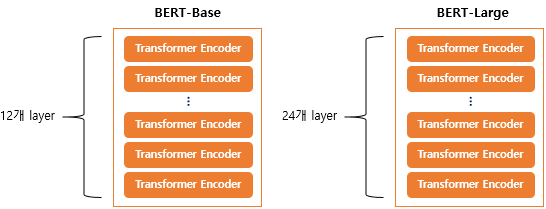

BERT의 기본구조는 트랜스포머의 인코더를 쌓아올린 구조임. Base 버전에서는 총 12개 쌓았으며, Large 버전에서는 총 24개 쌓았음. 그 외에도 Large 버전은 Base 버전보다 d_model의 크기나 셀프 어텐션 헤드의 수가 더 큼.


트랜스포머 인코더 층의 수를 L, d_model의 크기를 D, 셀프 어텐션 헤드의 수를 A라고 하였을때 각각의 크기는 다음과 같음


* BERT-Base: L=12, D=768, A=12 ==> 총 110M개 파라미터
* BERT-Large: L=24, D=1024, A=16, ==> 총 340M개 파라미터

초기 트랜스포머 모델이 L=6, D=512, A=8이었던 것과 비교하면 Base도 초기 트랜스포머모델보다 큰 네트워크임


여기서 BERT-base는 BERT보다 앞서 등장한 Open AI GPT-1과 하이퍼파라미터가 동일한데, 이는 BERT 연구진이 직접적으로 GPT-1과 성능을 비교하기 위해 GPT-1과 동등한 크기로 BERT-Base를 설계하였기 때문임


반면, BERT-Large는 BERT의 최대 성능을 보여주기 위해 만들어진 모델로 BERT가 세운 기록들은 대부분 BERT-Large를 통해 이루어짐


### 3. BERT의 문맥을 반영한 임베딩(Contextual Embedding)
---------------------------
BERT는 ELMo나 GPT-1과 마찬가지로 문맥을 반영한 임베딩(Contextual Embedding)을 사용하고 있음

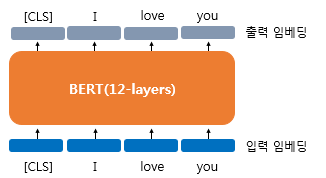

BERT의 입력은 앞서 배운 딥러닝 모델들과 마찬가지로 임베딩층(Embedding Layer)를 지난 임베딩 벡터들임. d_model을 768로 정의하였으므로, 모든 단어들은 768차원의 임베딩 벡터가 되어 BERT의 입력으로 사용됨


BERT는 내부 연산을 거친후, 동일하게 각 단어에 대하여 768차원의 벡터를 출력하게 됨. 위의 그림에서는 BERT가 각 768차원의 \[CLS], I, love, you라는 4개의 벡터를 입력받아서(입력 임베딩) 동일하게 768차원의 4개 벡터를 출력하는 모습(출력 임베딩)을 보여줌


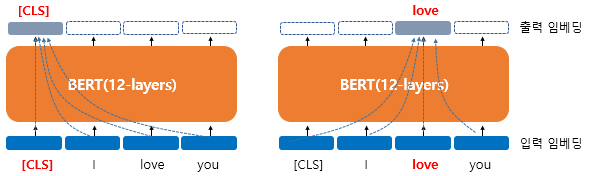

BERT의 연산을 거친 후의 출력임베딩은 문장의 문맥을 모두 참고한 문맥을 반영한 임베딩이 됨. 위의 좌측 그림에서 \[CLS]라는 벡터는 BERT의 초기입력으로 사용되었을 입력 임베딩 당시에는 단순히 임베딩 층(Embedding layer)을 지난 임베딩 벡터였지만, BERT를 지나고 나서는 \[CLS], I, love, you라는 모든 단어벡터들을 모두 참고한 후에 문맥정보를 가진 벡터가 됨. 위의 좌측그림에서는 모든 단어를 참고하고 있다는 것을 점선으로 표현함

이는 \[CLS]라는 단어 벡터뿐만 아니라 다른 벡터들도 전부 마찬가지임. 가령 우측의 그림에서 출력 임베딩 단계의 love를 보면, BERT의 입력이었던 모든 단어들인 \[CLS], I, love, you를 참고하고 있음

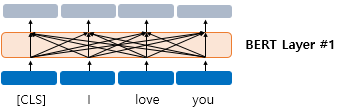





하나의 단어가 모든 단어를 참고하는 연산은 사실 BERT의 12개 층에서 전부 이루어지는 연산임. 그리고 이를 12개 층을 지나게 한 후에 최종적으로 출력 임베딩을 얻게 됨. 


가령, 위의 그림은 BERT의 첫번째 층에 입력된 각 단어가 모든 단어를 참고한 후에 출력되는 과정을 화살표로 표현함


BERT의 첫번째 층 출력 임베딩은 BERT의 두번째 층에서 입력 임베딩이 됨. 

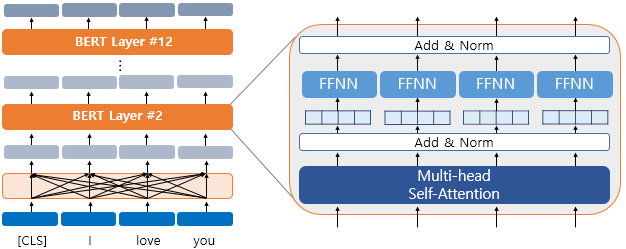


**그렇다면 BERT는 어떻게 모든 단어들을 참고하여 문맥을 반영한 출력 임베딩을 얻게 되는가?**

바로 **셀프어텐션**임. BERT는 기본적으로 트랜스포머 인코더를 12번 쌓은 것이므로 내부적으로 각 층마다 멀티헤드 어텐션과 포지션 와이즈 FFNN을 수행함




### 4. BERT의 서브워드 토크나이저 : WordPiece
--------------------
BERT는 단어보다 더 작은 단위로 쪼개는 서브워드 토크나이저를 사용함. BERT가 사용한 토크나이저는 WordPiece 토크나이저로 서브워드 토크나이저 챕터에서 공부한 바이트 페어 인코딩(Byte Pair Encoding, BPE)의 유사 알고리즘임

동작방식은 BPE와 조금 다르나, 글자로부터 서브워드들을 병합해 가는 방식으로 최종 단어 집합을 만드는 것을 BPE와 유사함

서브워드 토크나이저는 기본적으로 자주 등장하는 단어는 그대로 단어 집합에 추가하지만, 자주 등장하지 않는 단어의 경우에는 더 작은 단어인 서브워드로 분리되어 서브워드들이 단어 집합에 추가된다는 아이디어를 갖고 있음

이렇게 단어 집합이 만들어지고 나면, 이 단어집합을 기반으로 토큰화를 수행함

이는 대표적인 서브워드 토크나이저 패키지인 SentencePiece 실습을 통해 이해한 내용임

BERT의 서브워드 토크나이저도 이와 마찬가지로 다음과 같이 동작함

* 준비물 : 이미 훈련 데이터로부터 만들어진 단어 집합
  * 토큰이 단어 집합에 존재한다. => 해당 토큰을 분리하지 않음
  * 토큰이 단어집합에 존재하지 않는다 => 해당 토큰을 서브워드로 분리함. 해당 토큰의 첫번째 서브워드를 제외한 나머지 서브워드들은 앞에 "##"를 붙인 것을 토큰으로 함


예를 들어 embeddings라는 단어가 입력으로 들어왔을 때, BERT의 단어 집합에 해당 단어가 존재하지 않았다고 하자. 만약 서브워드 토크나이저가 아닌 토크나이저라면 여기서 OOV 문제가 발생함. 

하지만 서브워드 토크나이저의 경우에는 해당 단어가 단어집합에 존재하지 않았다고 해서 서브워드 또한 존재하지 않는다는 의미는 아니므로 해당 단어를 더 쪼개려고 시도함. 

만약 BERT의 단어집합에 em, ##bed, ##ding, #s라는 서브워드들이 존재한다면, embeddings는 em, ##bed, ##ding, #s로 분리됨.


실습!!


In [2]:
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
result = tokenizer.tokenize('Here is the sentence I want embeddings for.')

In [6]:
print(result)

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


embeddings라는 단어는 단어 집합에 존재하지 않으므로 em, ##bed, ##ding, #s로 분리됨. 실제로 BERT의 단어집합에 특정단어가 있는 조회하려면 .vocab[]을 통해 가능

In [7]:
print(tokenizer.vocab['here'])

2182


In [8]:
print(tokenizer.vocab['embeddings'])

KeyError: ignored

In [13]:
print(tokenizer.vocab['##bed'])

8270


In [14]:
print(tokenizer.vocab['bed'])

2793


In [15]:
# BERT의 단어 집합 전체를 불러와서 vocabulary.txt에 저장
with open('vocabulary.txt', 'w') as f:
  for token in tokenizer.vocab.keys():
    f.write(token + '\n')

In [18]:
# 확인
df = pd.read_fwf('vocabulary.txt', header=None)
df.tail()

,0
30517,##．
30518,##／
30519,##：
30520,##？
30521,##～


In [19]:
df.loc[102].values[0]

'[SEP]'

### 5. 포지션 임베딩(Position Embedding)
-----------------------------
트랜스포머에서는 포지셔널 임베딩(Positional Embedding)이라는 방법을 통해 단어의 위치정보를 표현함

포지셔널 인코딩은 사인함수와 코사인함수를 사용하여 위치에 따라 다른 값을 가지는 행렬을 만들어 이를 단어 벡터들과 더하는 방법임

BERT에서는 이와 유사하지만, 위치정보를 사인함수와 코사인함수로 만드는 것이 아닌 학습을 통해 얻는 포지션 임베딩(Position Embedding)이라는 방법을 사용함

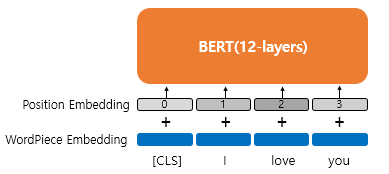



위의 그림은 포지션 임베딩을 사용하는 방법을 보여줌. 우선, 위의 그림에서 WordPiece Embedding은 우리가 이미 알고 있는 단어 임베딩으로 실질적인 입력임. 그리고 이 입력에 포지션 임베딩을 통해 위치정보를 더해 주어야 함


포지션 임베딩 아이디어는 굉장히 간단한데, 위치정보를 위한 임베딩 층을 하나 더 사용함. 가령, 문장의 길이가 4라면 4개의 포지션 임베딩 벡터를 학습시킴

그리고 BERT의 입력마다 다음과 같이 포지션 임베딩 벡터를 더해주는 것임

* 첫번째 단어의 임베딩 벡터 + 0번 포지션 임베딩 벡터
* 두번째 단어의 임베딩 벡터 + 1번 포지션 임베딩 벡터
* 세번째 단어의 임베딩 벡터 + 2번 포지션 임베딩 벡터
* 네번째 단어의 임베딩 벡터 + 3번 포지션 임베딩 벡터

실제 BERT에서는 문장의 최대 길이를 512로 하고 있으므로, 총 512개의 포지션 임베딩 벡터가 학습됨. 결론적으로 현재 설명한 내용을 기준으로는 BERT에서는 총 두개의 임베딩 층이 사용됨. 단어 집합의 크기가 30,522개인 단어벡터를 위한 임베딩 층과 문장의 최대 길이가 512이므로 512개의 포지션 벡터를 위한 임베딩 층임


사실 BERT는 세그먼트 임베딩이라는 1개의 임베딩 층을 더 사용함

### 6. BERT의 사전 훈련(Pre-training)
-------------------
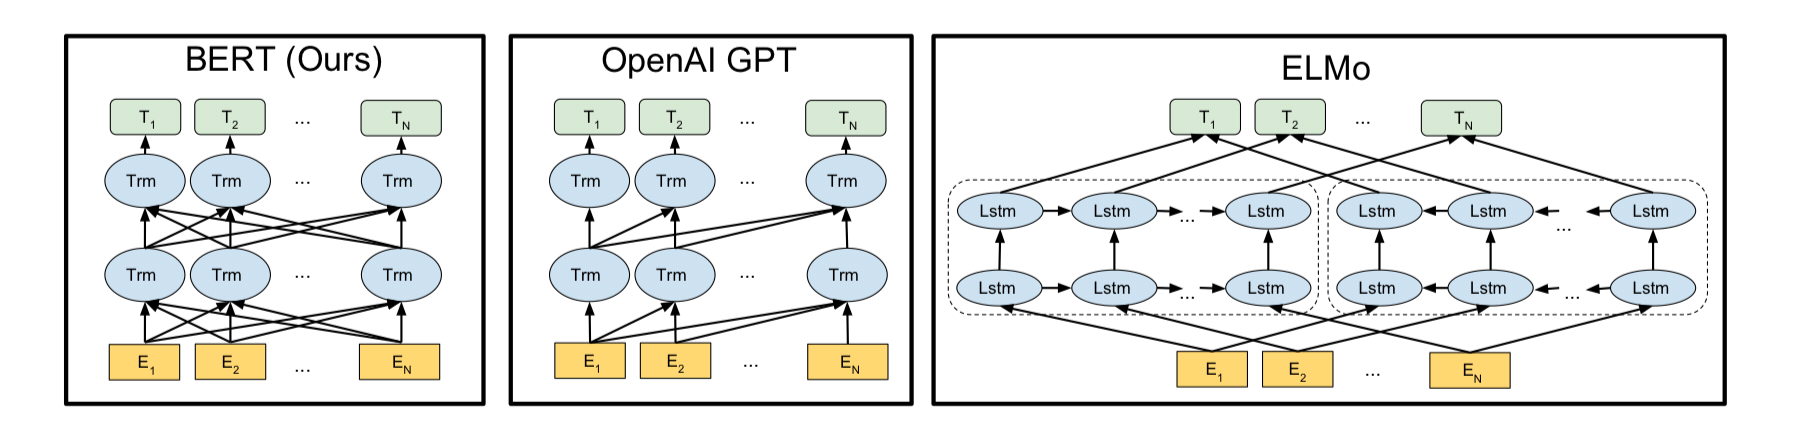

위의 그림은 BERT의 논문에 첨부된 그림으로 ELMo와 GPT-1, 그리고 BERT의 구조적인 차이를 보여줌. 가장 우측의 그림의 ELMo는 정방향 LSTM과 역방향 LSTM을 각각 훈련시키는 방식으로 양방향 언어모델을 만들었음

가운데 그림의 GPT-1은 트랜스포머의 디코더를 이전 단어들로부터 다음 단어를 예측하는 방식으로 단방향 언어모델을 만들었음. Trm은 트랜스포머를 의미함


단방향(->)으로 설계된 OpenAI GPT와 달리 가장 좌측 그림의 BERT는 화살표가 양방향으로 뻗어나가는 모습을 보여줌

이는 마스크드 언어 모델(Masked Language Model)을 통해 양방향성을 얻었기 때문임. **BERT의 사전 훈련방법은 크게 두가지로 나뉨.**

**첫번째는 마스크드 언어모델이고, 두번째는 다음 문장 예측(Next sentence prediction, NSP)임**

#### 1) 마스크드 언어모델(Masked Language Model, MLM)

BERT는 사전훈련을 위해서 인공신경망의 입력으로 들어가는 입력텍스트의 15% 단어를 랜덤으로 마스킹(Masking)함. 그리고 인공신경망에게 이 가려진 단어들을 예측하도록 함

중간에 단어들에 구멍을 뚫어놓고, 구멍에 들어갈 단어를 예측하게 하는 식임. 

더 정확히는 전부 \[MASK]로 변경하지 않고, 랜덤으로 선택된 15%의 단어들은 다시 다음과 같은 비율로 규칙이 적용됨

* 80%의 단어들은 \[MASK]로 변경됨
ex) The man went to the store --> the man went to the \[MASK]

* 10%의 단어들은 랜덤으로 단어가 변경됨
ex) The man went to the store --> The man went to the dog

* 10%의 단어들은 동일하게 둠
ex) The man went to the store --> The man went to the store

이렇게 하는 이유는 \[MASK]만 사용할 경우, \[MASK] 토큰이 파인튜닝 단계에서는 나타나지 않으므로 사전 학습단계와 파인튜닝 단계에서의 불일치가 발생하는 문제가 있음

이 문제를 완화하기 위해 랜덤으로 선택된 15%의 단어들의 모든 토큰을 \[MASK]로 사용하지 않음

이를 전체 단어 관점에서 그래프를 통해 정리하면 다음과 같음


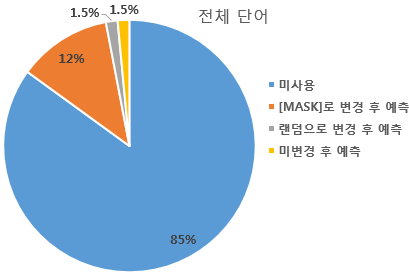

전체 단어의 85%는 마스크드 언어 모델의 학습에 사용되지 않음. 마스크드 언어 모델의 학습에 사용되는 단어는 전체 단어의 15%임. 이중 1.5%는 단어가 변경되지 않았지만, BERT는 이 단어가 변경된 단어인지 원래 단어인지 알 수 없음. 이 경우에도 BERT는 원래 단어가 무엇인지를 예측하도록 함


예를 들어, 'My dog is cute. he likes playing' 이라는 문장에 대해 마스크드 언어 모델을 학습하고자 함

약간의 전처리와 BERT의 서브워드 토크나이저를 통해 이 문장은 \['my', 'dog', 'is' 'cute', 'he', 'likes', 'play', '##ing']로 토큰화되어 BERT의 입력으로 사용됨.

그리고 언어모델 학습을 위해 다음과 같이 데이터가 변경되었다고 가정해 보자. 

* 'dog' 토큰은 \[MASK]로 변경

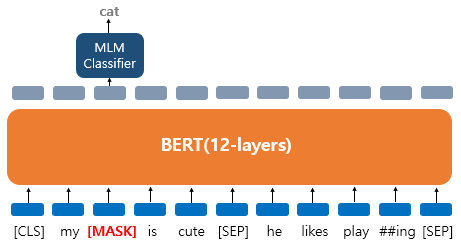

위 그림은 'dog' 토큰이 \[MASK]로 변경되어 BERT 모델이 원래 단어를 맞추려고 하는 모습을 보여줌. 여기서 출력층에 있는 다른 위치의 벡터들은 예측과 학습에 사용되지 않고, 오직 'dog' 위치의 출력층의 벡터만 사용됨


구체적으로는 BERT의 손실함수에서 다른 위치에서의 예측은 무시함. 출력층에서는 예측을 위해 단어 집합의 크기만큼의 밀집층(dense layer)에 소프트맥스 함수가 사용된 1개의 층을 사용하여 원래 단어가 무엇인지 맞추게 됨

그런데 만약 'dog'만 변경된 것이 아니라, 다음과 같이 데이터셋이 변경되었다면 어떨까? 이번에는 세가지 유형 모두에 대해 가정해 보자

* 'dog' 토큰은 \[MASK]로 변경됨
* 'he'는 랜덤 단어 'king'으로 변경됨
* 'play'는 변경되지 않았지만 예측에 사용됨

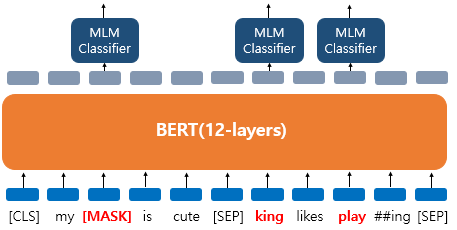





BERT는 랜덤단어 'king'으로 변경된 토큰에 대해서도 원래 단어가 무엇인지, 변경되지 않은 단어 'play'에 대해서도 원래 단어가 무엇인지 예측해야 함

BERT는 마스크드 언어모델 외에도 다음 문장 예측이라는 또 다른 태스크를 학습함

#### 2) 다음 문장 예측(Next Sentence Prediction, NSP)
BERT는 두개의 문장을 준 후에 이 문장이 이어지는 문장인지 아닌지를 맞추는 방식으로 훈련시킴

이를 위해 50:50 비율로 실제 이어지는 두개의 문장과 랜덤으로 이어붙인 두개의 문장을 주고 훈련시킴


이는 각각 sentence A와 sentence B라고 하였을 때, 다음의 예는 문장의 연속성을 확인한 경우와 그렇지 않은 경우를 보여줌

* 이어지는 문장의 경우
  * Sentence A : The man went to the store.
  * Sentnece B : He bought a gallon of milk.
  * Label = IsNextSentence
* 이어지는 문장이 아닌 경우
  * Sentence A : The man went to the store.
  * Sentence B : dogs are so cut.
  * Label = NotNextSentence


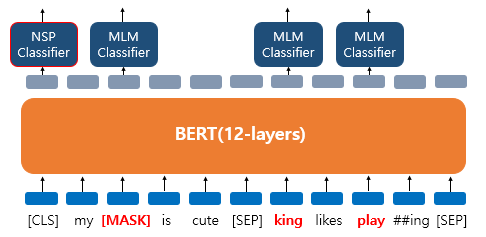

BERT의 입력으로 넣을때에는 \[SEP]라는 특별 토큰을 사용해서 문장을 구분함. 첫번째 문장의 끝에 \[SEP] 토큰을 넣고, 두번째 문장이 끝나면 역시 \[SEP] 토큰을 붙여줌. 

그리고 이 두 문장이 실제 이어지는 문장인지 아닌지를 **\[CLS] 토큰 위치의 출력층에서 이진 분류 문제를 풀도록 함**.

**\[CLS] 토큰은 BERT가 분류 문제를 풀기 위해 추가된 특별 토큰임.**

위의 그림에서 나타난 것과 같이 마스크드 언어모델과 다음 문장 예측은 **따로 학습하는 것이 아닌 loss를 합하여 학습이 동시에 이루어짐**

BERT가 언어 모델 외에도 다음 문장 예측이라는 태스크를 학습하는 이유는 BERT가 풀고자 하는 태스크 중에서는 QA(Question Answering)나 NLI(Natural Language Inference)과 같이 두 문장의 관계를 이해하는 것이 중요한 태스크들이 있기 때문임


### 7. 세그먼트 임베딩(Segment Embedding)
---------------------
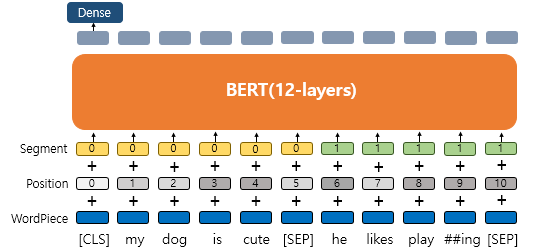



앞서 언급했듯이 BERT는 QA 등과 같은 문장 입력이 필요한 태스크를 풀기로 함. 문장 구분을 위해 BERT는 세그먼트 임베딩이라는 또 다른 임베딩 층(Embedding layer)을 사용함

첫번째 문장에는 Sentence 0 임베딩, 두번째 문장에는 Sentence 1 임베딩을 더해 주는 방식이며, 임베딩 벡터는 두개만 사용됨

**결론적으로 BERT는 총 3개의 임베딩 층이 사용됨**

* WordPiece Embedding : 실제 입력의 워드 임베딩. 임베딩 벡터의 종류는 단어집합의 크기로 30,522개
* Position Embedding : 위치정보를 학습하기 위한 임베딩. 임베딩 벡터의 종류는 문장의 최대 길이인 512개. 
* Segment Embedding : 두개의 문장을 구분하기 위한 임베딩. 임베딩 벡터의 종류는 문장의 최대 개수인 2개.

주의할 점은 많은 문헌에서 BERT가 문장 중간의 \[SEP] 토큰과 두 종류의 세그먼트 임베딩을 통해 두개의 문장을 구분하여 입력받을 수 있다고 설명하고 있지만, 여기서 BERT에 두개의 문장이 들어간다는 표현에서의 문장이라는 것은 실제 우리가 알고 있는 문장단위가 아님.

예를 들어, QA 문제를 푸는 경우에는 \[SEP]와 세그먼트 임베딩을 기준으로 구분되는 \[질문(Question), 본문(Paragraph)] 두 종류의 텍스트를 입력받지만, Paragraph 1개는 실제로는 다수의 문장으로 구성될 수 있음

다시 말해, \[SEP]와 세그먼트 임베딩으로 구분되는 BERT의 입력에서의 두개 문장은 실제로는 두 종류의 텍스트, 두개의 문서일 수 있음

BERT가 두개의 문장을 입력받을 필요가 없는 경우도 있음. 예를 들어 네이버 영화 리뷰 분류나 IMDB 리뷰 분류와 같은 감성 분류 태스크에서는 한개의 문서에 대해서만 분류를 하는 것이므로, 이 경우에는 BERT의 전체 입력에 Sentence 0 임베딩만을 더해 줌. 아래에서 설명할 1)과 2) 파인 튜닝유형이 그 예라고 할 수 있음

### 8. BERT를 파인 튜닝(Fine-tunning)하기
----------------
이번에는 사전 학습된 BERT에 우리가 풀고자 하는 태스크의 데이터를 추가로 학습시켜 테스트하는 단계인 파인튜닝 단계에 대해 알아보자. 실질적으로 태스크에 BERT를 사용하는 단계에 해당함


#### 1) 하나의 텍스트에 대한 텍스트 분류 유형
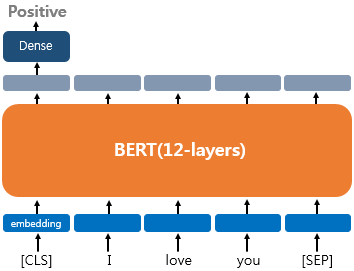


BERT를 사용하는 첫번째 유형은 하나의 문서에 대한 텍스트 분류 유형임. 이 유형은 영화 리뷰감성 분류, 로이터 뉴스 분류 등과 같이 입력된 문서에 대해 분류를 하는 유형으로 문서의 시작에 \[CLS]라는 토큰을 입력함


앞서 사전 훈련 단계에서 다음 문장 예측을 설명할 때, \[CLS] 토큰은 BERT가 분류 문제를 풀기 위한 특별 토큰이라고 언급한바 있음. 이는 BERT를 실질적으로 사용하는 단계인 파인 튜닝 단계에서도 마찬가지임

텍스트 분류 문제를 풀기 위해 \[CLS] 토큰의 위치 출력층에서 밀집층(Dense Layer) 또는 같은 이름으로는 완전 연결층(fully-connected layer)이라고 불리는 층들을 추가하여 분류에 대한 예측을 하게 됨


#### 2) 하나의 텍스트에 대한 태깅 작업(Tagging)
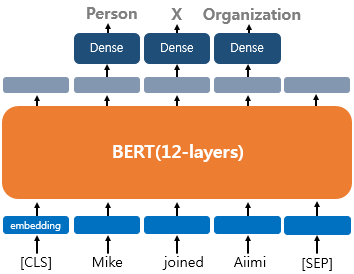

BERT를 사용하는 두번째 유형은 태깅 작업임. 앞서 RNN 계열의 신경망들을 이용해서 풀었던 태스크임. 

대표적으로 **문장의 각 단어에 품사를 태깅하는 품사 태깅 작업과 개체를 태깅하는 개체명 인식 작업**이 있음. 

출력층에서 입력텍스트의 각 토큰 위치에 밀집층을 사용하여 분류에 대한 예측을 하게 됨




#### 3) 텍스트의 쌍에 대한 분류 또는 회귀 문제(Text Pair Classification or Regression)

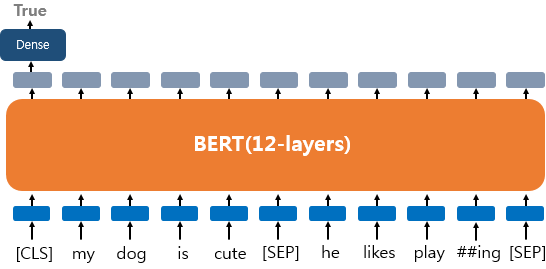


BERT는 텍스트 쌍을 입력으로 받는 태스크로 대표적인 예로 자연어 추론(Natural Languate Inference)이 있음

자연어 추론이란, 두 문장이 주어졌을 때, 하나의 문장이 다른 문장과 논리적으로 어떤 관계에 있는지를 분류하는 것임

유형으로는 모순 관계(contradiction), 함의 관계(entailment), 중립관계(neutral)가 있음


텍스트의 쌍을 입력받는 이러한 태스크의 경우, 입력텍스트가 1개가 아니므로, 텍스트 사이에 \[SEP] 토큰을 집어넣고, Sentence 0 임베딩과 Sentence 1 임베딩이라는 두 종류의 세그먼트 임베딩을 모두 사용하여 문서를 구분함


#### 4) 질의 응답(Question Answering)
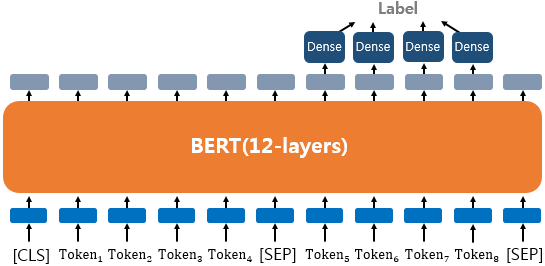

텍스트 쌍을 입력으로 받는 또 다른 태스크로 QA(Qustion Answering)가 있음. BERT로 QA를 풀기 위해 질문과 본문이라는 두개의 텍스트 쌍을 입력함

이 태스크의 대표적인 데이터셋으로 SQuAD(Standard Question Answering Dataset) v1.1이 있음

이 데이터셋을 푸는 방법은 질문과 본문을 입력받으면, 본문의 일부분을 추출해서 질문에 답변하는 것임


### 9. 그 외 기타
----------------
* 훈련 데이터는 위키피디아(25억 단어)와 BooksCorpus(8억 단어) : 약 33억 단어
* WordPiece 토크나이저로 토큰화를 수행한 후 15% 비율에 대해 마스크드 언어 모델 학습
* 두문장 Sentence A와 B의 합한 길이. 즉, 최대 입력의 길이는 512로 제한
* 100만 step 훈련 : 총 합 33억 단어 코퍼스에 대해 40 에포크 학습
* 옵티마이저 : 아담(Adma)
* 학습률 : $10^{−4}$
* 가중치 감소(Weight Decay): L2 정규화로 0.01 적용
* 드롭아웃 : 모든 레이어에 대해 0.1 적용
* 활성화 함수 : relu 함수가 아닌 gelu 함수 적용
* 배치크기 : 25YsmT6yltCAhQUwHe

### 10. 어텐션 마스크(Attention Mask)
-------------------
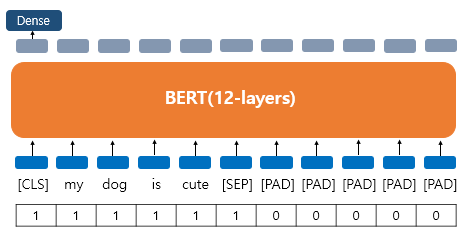



BERT를 실제로 실습하게 되면, 어텐션 마스크라는 시퀀스 입력이 추가로 필요함. 어텐션 마스크는 BERT가 어텐션 연산을 할 때 불필요하게 패딩 토큰에 대해 어텐션을 하지 않도록 실제 단어와 패딩 토큰을 구분할 수 있도록 알려주는 입력임


이 값은 0과 1 두가지 값을 가지는데, 숫자 1은 해당 토큰은 실제 단어이므로 마스킹을 하지 않는다라는 의미이고, 숫자 0은 해당 토큰이 패딩 토큰이므로 마스킹을 한다는 의미임

위의 그림과 같이 실제 단어의 위치에는 1, 패딩 토큰의 위치에는 0의 값을 가지는 시퀀스를 만들어 BERT의 또 다른 입력으로 사용하면 됨